In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = kagglehub.dataset_download("bejopamungkas/transaksi-pembelian-penjualan-sembako")

df_pemasukan_barang = pd.read_csv(path + '\\pemasukan barang.csv')
df_penjualan_barang = pd.read_csv(path + '\\penjualan barang.csv')

c:\Users\51206614\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Summary Keseluruhan

In [2]:
jml_barang_masuk = df_pemasukan_barang.groupby([pd.Grouper(key='nama.barang')]).sum().kuantum
jml_barang_dijual = df_penjualan_barang.groupby([pd.Grouper(key='nama.barang')]).sum().kuantum
total_pemasukan = df_penjualan_barang.groupby([pd.Grouper(key='nama.barang')]).sum().nominal
sisa_stock = jml_barang_masuk - jml_barang_dijual

##### Reporting

In [6]:
data_pemasukan = df_pemasukan_barang.groupby(['tanggal', 'nama.barang'], as_index=False).sum()
data_penjualan = df_penjualan_barang.groupby(['tanggal', 'nama.barang'], as_index=False).sum()

data_penjualan

,tanggal,nama.barang,Unnamed: 0,nama.pembeli,kuantum,nominal
0,2020-01-02,BERAS,17,TOKO HERUNIAWATITOKO APRILIA SUKRISNITOKO MAJU...,8370.0,86759700.0
1,2020-01-02,DAGING,10,TOKO HERUNIAWATITOKO MAJU TERUS,260.0,18200000.0
2,2020-01-02,MIGOR,4,TOKO APRILIA SUKRISNI,408.0,4855200.0
3,2020-01-02,TEPUNG,5,TOKO APRILIA SUKRISNI,140.0,1162000.0
4,2020-01-03,BERAS,9,KOPERASI BRI MELAWI,1180.0,12372300.0
...,...,...,...,...,...,...
368,2021-04-08,DAGING,1285,TOKO MAJU TERUS,60.0,4389600.0
369,2021-04-08,GULA,1284,TOKO MAJU TERUS,100.0,1200000.0
370,2021-04-08,TEPUNG,1287,TOKO KINORA,120.0,1065120.0
371,2021-04-09,DAGING,1289,TOKO BERKAH DUA PUTRA,80.0,5852800.0


### Peringkat Pembeli

In [24]:
pembeli = df_penjualan_barang.groupby([pd.Grouper(key='nama.pembeli')]).sum().sort_values('nominal',ascending=False).nominal.head(10)
pembeli.apply(lambda x: "Rp" + "{:,.0f}".format(x).replace(",", "."))

nama.pembeli
TOKO ENGKON                Rp2.047.000.000
TOKO AIDI K.               Rp1.955.568.240
TOKO ENDANG SUSILAWATI     Rp1.394.936.500
TOKO DEWI AFRITA             Rp968.623.080
TOKO YAKOB                   Rp539.014.900
TOKO HERWIN                  Rp525.000.000
TOKO ANDREAS INDAH           Rp456.947.700
TOKO JESAYA GINTING          Rp440.962.500
TOKO FAKHLI HARUDI           Rp430.245.000
TOKO AGUSTINUS               Rp401.352.500
Name: nominal, dtype: object

### Summary Per-hari

In [15]:
df_pemasukan_barang_group = df_pemasukan_barang.groupby(['tanggal', 'nama.barang'], as_index=False).sum()
df_penjualan_barang_group = df_penjualan_barang.groupby(['tanggal', 'nama.barang','nama.pembeli'], as_index=False).sum()

### Ploting

In [45]:
def plotting(nama_toko):
    sns.set(style="whitegrid")
    
    data_pemasukan = df_pemasukan_barang.groupby(['tanggal', 'nama.barang'], as_index=False).sum()
    data_penjualan = df_penjualan_barang.groupby(['tanggal', 'nama.barang'], as_index=False).sum()
    
    data_pemasukan['tanggal'] = pd.to_datetime(data_pemasukan['tanggal'])
    data_penjualan['tanggal'] = pd.to_datetime(data_penjualan['tanggal'])
    
    data_pemasukan_filtered = data_pemasukan[data_pemasukan['nama.barang'] == nama_toko.upper()]
    data_penjualan_filtered = data_penjualan[data_penjualan['nama.barang'] == nama_toko.upper()]
    
    plt.figure(figsize=(12, 7))
    
    plt.plot(data_pemasukan_filtered['tanggal'], data_pemasukan_filtered['kuantum'],
             linestyle='-', linewidth=2, markersize=8, label='Pemasukan')
    
    plt.plot(data_penjualan_filtered['tanggal'], data_penjualan_filtered['kuantum'],
             linestyle='-', linewidth=2, markersize=8, label='Penjualan')
    
    plt.xlabel('Tanggal', fontsize=14)
    plt.ylabel('Kuantum', fontsize=14)
    plt.title(f"Tren Kuantum Barang {nama_toko.upper()} (Pemasukan vs Penjualan)", fontsize=16)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

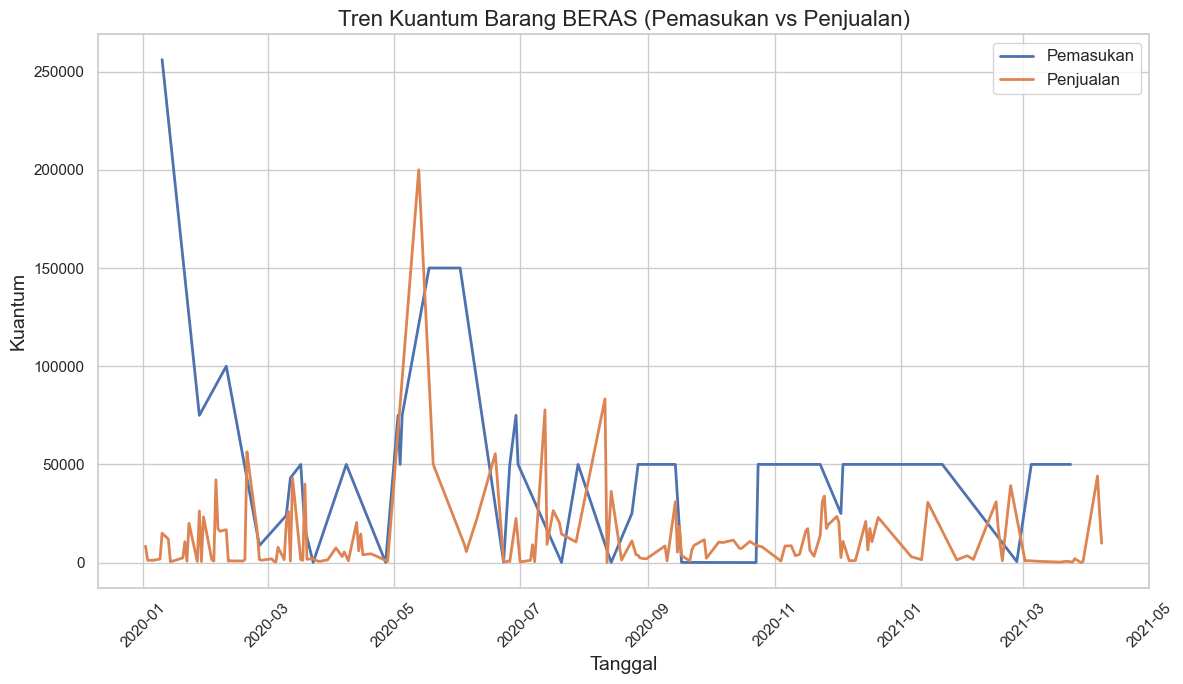

In [46]:
plotting('beras')

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plotting(nama_toko):
    sns.set(style="whitegrid")

    # Grouping data penjualan berdasarkan tanggal dan nama pembeli
    data_penjualan = df_penjualan_barang.groupby(['tanggal', 'nama.pembeli'], as_index=False).sum()

    # Konversi tanggal menjadi datetime
    data_penjualan['tanggal'] = pd.to_datetime(data_penjualan['tanggal'])

    # Filter hanya untuk toko tertentu
    data_penjualan_filtered = data_penjualan[data_penjualan['nama.pembeli'] == nama_toko.upper()]

    # Jika data kosong, beri warning
    if data_penjualan_filtered.empty:
        print(f"Tidak ada data untuk toko {nama_toko}")
        return

    plt.figure(figsize=(10, 5))

    # Menggunakan Seaborn untuk lineplot yang lebih smooth
    sns.lineplot(x=data_penjualan_filtered['tanggal'], 
                 y=data_penjualan_filtered['nominal'] / 1_000_000,  # Menggunakan satuan juta
                 marker='o', linewidth=2, label="Penjualan")

    # Format plot
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Nominal (Juta Rupiah)', fontsize=12)
    plt.title(f"Tren Penjualan {nama_toko.upper()} dari Waktu ke Waktu", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Tampilkan plot
    plt.show()
